In [1]:
import pandas as pd
import numpy as np

import glob
import xarray as xr

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 

from sklearn.linear_model import LinearRegression

from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series

import seaborn as sns

from standard_precip.spi import SPI
from standard_precip.utils import plot_index

import geopandas as gpd

from shapely.geometry import Point

from scipy.interpolate import Rbf

from pykrige.ok import OrdinaryKriging

import skgstat as skg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

In [75]:
#load df
feature_df = pd.read_csv('../data/almost_final_final_df.csv', header=0, index_col = 0)
feature_df.reset_index(inplace=True)

feature_df.rename(columns={'Soil Zone': 'soil_zone'}, inplace=True)

columns = feature_df.columns.tolist()

# Swap the first and second column names in the list
columns[1], columns[2] = columns[2], columns[1]
columns[24], columns[25] = columns[25], columns[24]

feature_df['Year'] = feature_df['Year'].astype('category')
feature_df['region'] = feature_df['region'].astype('category')
feature_df['soil_zone'] = feature_df['soil_zone'].astype('category')

# Reorder the DataFrame according to the new list of column names
feature_df = feature_df[columns]

feature_df.head(5)


,Year,region,Canola,average_max_temp_in_4,average_max_temp_in_5,average_max_temp_in_6,average_max_temp_in_7,average_max_temp_in_8,average_max_temp_in_9,average_max_temp_in_10,...,SPI_in_6,SPI_in_7,SPI_in_8,SPI_in_9,SPI_in_10,soil_zone,Region,Latitude,Longitude,region_aggregate
0,1990,1,0.127132,284.965759,290.526489,297.082458,299.412781,300.752075,296.791382,286.036377,...,0.115236,0.209242,0.256968,0.171961,-0.032910,1,1,49.154052,-101.479393,Southeastern
1,1991,1,2.520378,287.648346,291.984650,296.854401,297.652344,299.938751,292.543549,282.321960,...,0.195163,0.282696,0.222439,0.398697,0.232995,1,1,49.154052,-101.479393,Southeastern
2,1992,1,-6.339489,283.242584,293.701874,295.445709,294.548126,297.033264,292.229004,285.503967,...,-0.188189,0.358708,0.309846,0.225539,-0.114548,1,1,49.154052,-101.479393,Southeastern
3,1993,1,4.147971,284.697113,292.762695,293.425385,294.037415,296.177429,291.031281,284.688232,...,0.086120,0.608185,0.263007,0.235375,-0.044934,1,1,49.154052,-101.479393,Southeastern
4,1994,1,2.081733,285.144440,293.432678,294.774536,297.061951,297.072021,294.903839,286.052094,...,0.446020,0.102491,0.320304,0.034789,0.322164,1,1,49.154052,-101.479393,Southeastern


In [3]:
feature_df['Year'] = feature_df['Year'].astype('category')
feature_df['region'] = feature_df['region'].astype('category')
feature_df['soil_zone'] = feature_df['soil_zone'].astype('category')

print(feature_df.dtypes)
#print(feature_df.columns)

Year                          category
region                        category
Canola                         float64
average_max_temp_in_4          float64
average_max_temp_in_5          float64
average_max_temp_in_6          float64
average_max_temp_in_7          float64
average_max_temp_in_8          float64
average_max_temp_in_9          float64
average_max_temp_in_10         float64
days_above_25                    int64
days_under_0                     int64
longest_dry_spell                int64
longest_wet_spell                int64
days_over_95_precipitation       int64
longest_heat_wave                int64
longest_cold_wave                int64
SPI_in_4                       float64
SPI_in_5                       float64
SPI_in_6                       float64
SPI_in_7                       float64
SPI_in_8                       float64
SPI_in_9                       float64
SPI_in_10                      float64
soil_zone                     category
Region                   

In [4]:
## Morans' I

import libpysal
from libpysal.weights import Queen
from libpysal.weights import KNN
from esda.moran import Moran
import statsmodels.api as sm

feature_df_1990 =  feature_df[feature_df['Year'] == 1990]
feature_df_1990

#Assuming 'df' is your DataFrame and it contains 'longitude' and 'latitude'
coordinates = feature_df_1990[['Longitude', 'Latitude']].values

w = libpysal.weights.KNN.from_array(coordinates, k=6)
w.transform = 'r' 

from esda.moran import Moran
import statsmodels.api as sm

# Moran's I for the response variable
mi_canola = Moran(feature_df_1990['Canola'], w)
print(f"Moran's I for Canola: {mi_canola.I}, p-value: {mi_canola.p_sim}")
    
# Fit a model (example with OLS, adjust according to your needs)
X = sm.add_constant(feature_df_1990[['average_max_temp_in_4',
       'average_max_temp_in_5', 'average_max_temp_in_6',
       'average_max_temp_in_7', 'average_max_temp_in_8',
       'average_max_temp_in_9', 'average_max_temp_in_10', 'days_above_25',
       'days_under_0', 'longest_dry_spell', 'longest_wet_spell',
       'days_over_95_precipitation', 'longest_heat_wave', 'longest_cold_wave',
       'SPI_in_4', 'SPI_in_5', 'SPI_in_6', 'SPI_in_7', 'SPI_in_8', 'SPI_in_9',
       'SPI_in_10', 'soil_zone']])  
y = feature_df_1990['Canola']
model = sm.OLS(y, X).fit()

# Calculate Moran's I for the residuals
residuals = model.resid
mi_residuals = Moran(residuals, w)
print(f"Moran's I for residuals: {mi_residuals.I}, p-value: {mi_residuals.p_sim}")




Moran's I for Canola: 0.5076327636067202, p-value: 0.001
Moran's I for residuals: 0.07680008911268617, p-value: 0.028


In [5]:
from esda.moran import Moran
import statsmodels.api as sm

# Moran's I for the response variable
mi_canola = Moran(feature_df_1990['Canola'], w)
print(f"Moran's I for Canola: {mi_canola.I}, p-value: {mi_canola.p_sim}")
    
# Fit a model (example with OLS, adjust according to your needs)
X = sm.add_constant(feature_df_1990[['average_max_temp_in_4',
       'average_max_temp_in_5', 'average_max_temp_in_6',
       'average_max_temp_in_7', 'average_max_temp_in_8',
       'average_max_temp_in_9', 'average_max_temp_in_10', 'days_above_25',
       'days_under_0', 'longest_dry_spell', 'longest_wet_spell',
       'days_over_95_precipitation', 'longest_heat_wave', 'longest_cold_wave',
       'SPI_in_4', 'SPI_in_5', 'SPI_in_6', 'SPI_in_7', 'SPI_in_8', 'SPI_in_9',
       'SPI_in_10', 'soil_zone']])  
y = feature_df_1990['Canola']
model = sm.OLS(y, X).fit()

# Calculate Moran's I for the residuals
residuals = model.resid
mi_residuals = Moran(residuals, w)
print(f"Moran's I for residuals: {mi_residuals.I}, p-value: {mi_residuals.p_sim}")


Moran's I for Canola: 0.5076327636067202, p-value: 0.001
Moran's I for residuals: 0.07680008911268617, p-value: 0.029


In [6]:
import libpysal
from libpysal.weights import KNN
from esda.moran import Moran
import statsmodels.api as sm
import pandas as pd

# Assuming 'feature_df' is your DataFrame with all years and it includes columns 'Year', 'Longitude', 'Latitude', 'Canola', etc.

for year in range(1990, 2023):  # 2022 is included
    print(f"Year: {year}")
    feature_df_year = feature_df[feature_df['Year'] == year]

    # Extract coordinates
    coordinates = feature_df_year[['Longitude', 'Latitude']].values

    # Create spatial weights
    w = KNN.from_array(coordinates, k=6)
    w.transform = 'r'

    # Moran's I for the response variable
    mi_canola = Moran(feature_df_year['Canola'], w)
    print(f"  Moran's I for Canola: {mi_canola.I}, p-value: {mi_canola.p_sim}")

    # Fit a model (OLS as an example)
    explanatory_vars = ['average_max_temp_in_4', 'average_max_temp_in_5', 'average_max_temp_in_6',
                        'average_max_temp_in_7', 'average_max_temp_in_8', 'average_max_temp_in_9',
                        'average_max_temp_in_10', 'days_above_25', 'days_under_0', 'longest_dry_spell',
                        'longest_wet_spell', 'days_over_95_precipitation', 'longest_heat_wave',
                        'longest_cold_wave', 'SPI_in_4', 'SPI_in_5', 'SPI_in_6', 'SPI_in_7',
                        'SPI_in_8', 'SPI_in_9', 'SPI_in_10', 'soil_zone']
    
    X = sm.add_constant(feature_df_year[explanatory_vars])
    y = feature_df_year['Canola']
    model = sm.OLS(y, X).fit()

    # Calculate Moran's I for the residuals
    residuals = model.resid
    mi_residuals = Moran(residuals, w)
    print(f"  Moran's I for residuals: {mi_residuals.I}, p-value: {mi_residuals.p_sim}")
    print("\n")  # Print a newline for better readability between years


Year: 1990
  Moran's I for Canola: 0.5076327636067202, p-value: 0.001
  Moran's I for residuals: 0.07680008911268617, p-value: 0.03


Year: 1991
  Moran's I for Canola: 0.2417717580758441, p-value: 0.001
  Moran's I for residuals: 0.09751749100169078, p-value: 0.005


Year: 1992
  Moran's I for Canola: 0.3787076504579765, p-value: 0.001
  Moran's I for residuals: -0.025956076620403685, p-value: 0.309


Year: 1993
  Moran's I for Canola: 0.6052487940382816, p-value: 0.001
  Moran's I for residuals: 0.021281438185001392, p-value: 0.262


Year: 1994
  Moran's I for Canola: 0.29380621426740183, p-value: 0.001
  Moran's I for residuals: 0.04128195445251446, p-value: 0.093


Year: 1995
  Moran's I for Canola: 0.5443465782667065, p-value: 0.001
  Moran's I for residuals: 0.010718768240600345, p-value: 0.324


Year: 1996
  Moran's I for Canola: 0.23891992623792244, p-value: 0.001
  Moran's I for residuals: 0.03565263372637787, p-value: 0.162


Year: 1997
  Moran's I for Canola: 0.5365649021456

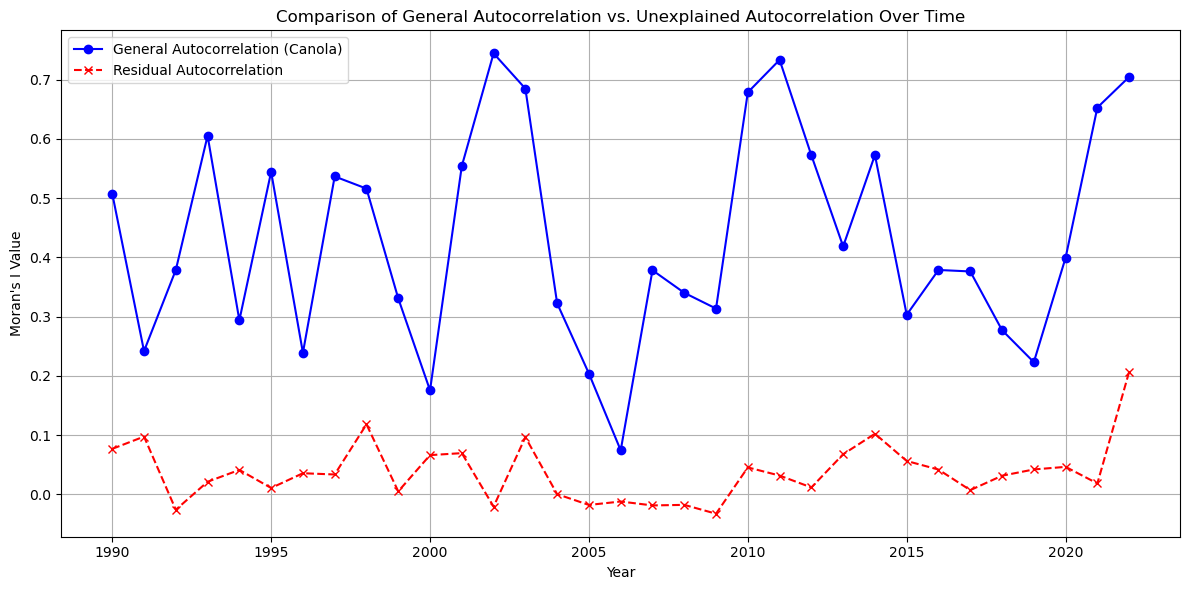

In [8]:
import matplotlib.pyplot as plt
import libpysal
from libpysal.weights import KNN
from esda.moran import Moran
import statsmodels.api as sm
import pandas as pd

# Initialize lists to store Moran's I values
moran_canola_values = []
moran_residuals_values = []
years = range(1990, 2023)

for year in years:
    feature_df_year = feature_df[feature_df['Year'] == year]
    coordinates = feature_df_year[['Longitude', 'Latitude']].values
    w = KNN.from_array(coordinates, k=6)
    w.transform = 'r'
    
    # Moran's I for Canola
    mi_canola = Moran(feature_df_year['Canola'], w)
    moran_canola_values.append(mi_canola.I)
    
    # Fit a model and calculate Moran's I for residuals
    explanatory_vars = ['average_max_temp_in_4', 'average_max_temp_in_5', 'average_max_temp_in_6',
                        'average_max_temp_in_7', 'average_max_temp_in_8', 'average_max_temp_in_9',
                        'average_max_temp_in_10', 'days_above_25', 'days_under_0', 'longest_dry_spell',
                        'longest_wet_spell', 'days_over_95_precipitation', 'longest_heat_wave',
                        'longest_cold_wave', 'SPI_in_4', 'SPI_in_5', 'SPI_in_6', 'SPI_in_7',
                        'SPI_in_8', 'SPI_in_9', 'SPI_in_10', 'soil_zone']
    
    X = sm.add_constant(feature_df_year[explanatory_vars])
    y = feature_df_year['Canola']
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    mi_residuals = Moran(residuals, w)
    moran_residuals_values.append(mi_residuals.I)


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming moran_canola_values and moran_residuals_values are populated as before
years = list(range(1990, 2023))

# Creating a DataFrame for easier plotting with seaborn
data = {
    "Year": years * 2,  # Repeat the years list twice
    "Moran's I": moran_canola_values + moran_residuals_values,  # Concatenate the values lists
    "Type": ["Canola"] * len(years) + ["Residuals"] * len(years)  # Label the first half as 'Canola' and the second half as 'Residuals'
}

df_plot = pd.DataFrame(data)

# Creating the plot
plt.figure(figsize=(12, 6))

# Plotting both sets of Moran's I values
plt.plot(years, moran_canola_values, marker='o', linestyle='-', color='blue', label='General Autocorrelation (Canola)')
plt.plot(years, moran_residuals_values, marker='x', linestyle='--', color='red', label='Residual Autocorrelation')

# Adding labels and legend
plt.title('Comparison of General Autocorrelation vs. Unexplained Autocorrelation Over Time')
plt.xlabel('Year')
plt.ylabel("Moran's I Value")
plt.legend()

plt.grid(True)
plt.tight_layout()

plt.savefig("../plots/spatial_autocorrelation_plt.png", dpi=300) 

plt.show()



In [14]:
sum(moran_canola_values)/len(moran_canola_values)

0.4326009923268911

In [15]:
X_to_scale = feature_df.iloc[:, 3:24]

# Create the scaler and fit_transform the selected part
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_scale)

# Step 2: Convert the scaled array back into a DataFrame
# This retains the original indexes and column names
X_scaled_df = pd.DataFrame(X_scaled, index=X_to_scale.index, columns=X_to_scale.columns)

# Step 3: Combine the scaled part with the unscaled parts of the original DataFrame
# First, select the columns not to be scaled (everything before column 2 and after column 23)
unscaled_part_left = feature_df.iloc[:, :3]
unscaled_part_right = feature_df.iloc[:, 24:]

# Now, concatenate all parts back together
feature_df_scaled = pd.concat([unscaled_part_left, X_scaled_df, unscaled_part_right], axis=1)

# feature_df_scaled now has the scaled and unscaled parts combined
feature_df_scaled.head()

,Year,region,Canola,average_max_temp_in_4,average_max_temp_in_5,average_max_temp_in_6,average_max_temp_in_7,average_max_temp_in_8,average_max_temp_in_9,average_max_temp_in_10,...,SPI_in_6,SPI_in_7,SPI_in_8,SPI_in_9,SPI_in_10,soil_zone,Region,Latitude,Longitude,region_aggregate
0,1990,1,0.127132,0.764381,0.286853,1.561226,1.222256,1.767378,1.973032,1.389025,...,-0.017329,0.154150,0.391599,-0.080126,-0.793221,1,1,49.154052,-101.479393,Southeastern
1,1991,1,2.520378,1.642098,1.049150,1.433955,0.297337,1.395298,0.306723,-0.036611,...,0.359425,0.504168,0.243603,0.831369,0.284727,1,1,49.154052,-101.479393,Southeastern
2,1992,1,-6.339489,0.200574,1.946881,0.647812,-1.333594,0.066095,0.183335,1.184680,...,-1.447601,0.866371,0.618242,0.135260,-1.124172,1,1,49.154052,-101.479393,Southeastern
3,1993,1,4.147971,0.676482,1.455897,-0.479661,-1.601917,-0.325432,-0.286499,0.871592,...,-0.154576,2.055151,0.417483,0.174803,-0.841967,1,1,49.154052,-101.479393,Southeastern
4,1994,1,2.081733,0.822843,1.806151,0.273254,-0.012851,0.083826,1.232600,1.395057,...,1.541900,-0.354526,0.663063,-0.631563,0.646210,1,1,49.154052,-101.479393,Southeastern


In [16]:
#VIF Test 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# between 1 and 5 suggest moderate correlation

                      Variable           VIF
0                        const  2.929099e+06
1        average_max_temp_in_4  2.657613e+01
2        average_max_temp_in_5  2.583987e+01
3        average_max_temp_in_6  2.904896e+01
4        average_max_temp_in_7  3.306428e+01
5        average_max_temp_in_8  4.531690e+01
6        average_max_temp_in_9  3.048870e+01
7       average_max_temp_in_10  3.507235e+01
8                days_above_25  3.096907e+01
9                 days_under_0  5.241681e+00
10           longest_dry_spell  1.974288e+00
11           longest_wet_spell  1.632433e+00
12  days_over_95_precipitation  4.568905e+00
13           longest_heat_wave  2.006252e+00
14           longest_cold_wave  1.617503e+00
15                    SPI_in_4  5.817724e+00
16                    SPI_in_5  6.675364e+00
17                    SPI_in_6  4.753084e+00
18                    SPI_in_7  1.112109e+01
19                    SPI_in_8  8.132944e+00
20                    SPI_in_9  2.787430e+00
21        

## Lasso 

In [17]:

X_train_scaled = feature_df_scaled.iloc[:, 3:25]
y_train = feature_df_scaled['Canola']


In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# Create a Lasso regression model
lasso = Lasso()

# Set up the alpha values to test
alphas = np.arange(0, 10.1, 0.1)  # You can adjust this list based on your requirements

# Define the parameter grid for GridSearchCV
param_grid = {'alpha': alphas}

# Create the GridSearchCV object
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha from the grid search
best_alpha = grid_search.best_params_['alpha']

# Print the best alpha
print("Best Alpha:", best_alpha)

#best_alpha = 0.5

# Create and fit the Lasso regression model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# # Predict on the test set
# y_pred = lasso_best.predict(X_test)

# # Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

# Print the coefficients
print("Coefficients:", lasso_best.coef_)

print(X_train_scaled.columns[lasso_best.coef_ != 0])


C:\Users\maris\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.078e+04, tolerance: 2.415e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

Best Alpha: 0.0
Coefficients: [-1.22291349  1.15894469  0.72054644 -0.87213582  0.56464658  1.04495226
 -0.3378975  -2.27200316 -2.112049   -0.63384608 -0.4422031   0.02921717
 -0.4533774   0.44319476  0.49329729 -0.11084848  0.45028255  1.22935759
 -1.14961996  1.73078592  0.73557631  0.33470621]
Index(['average_max_temp_in_4', 'average_max_temp_in_5',
       'average_max_temp_in_6', 'average_max_temp_in_7',
       'average_max_temp_in_8', 'average_max_temp_in_9',
       'average_max_temp_in_10', 'days_above_25', 'days_under_0',
       'longest_dry_spell', 'longest_wet_spell', 'days_over_95_precipitation',
       'longest_heat_wave', 'longest_cold_wave', 'SPI_in_4', 'SPI_in_5',
       'SPI_in_6', 'SPI_in_7', 'SPI_in_8', 'SPI_in_9', 'SPI_in_10',
       'soil_zone'],
      dtype='object')


C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.078e+04, tolerance: 2.415e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80843.852597972, tolerance: 24.153972696292
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\maris\AppData\Local\Temp\ipykernel_31008\1653270081.py:11: RuntimeWarning: divide by zero encountered in log10
  neg_log_alphas_lasso = np.log10(alphas_lasso)


(-1.1, 1.1, -1.8109350326694484, 1.4096899757593482)

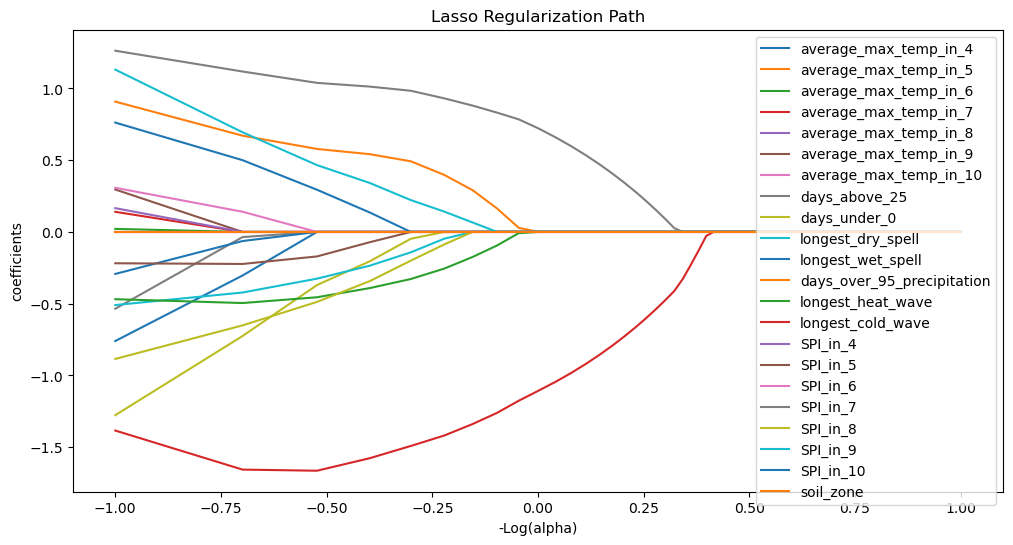

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, lasso_path, enet_path
from sklearn.preprocessing import StandardScaler

# Create a range of alpha values
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=np.arange(0, 10.1, 0.1))

# Plot the Lasso regularization path
plt.figure(figsize=(12, 6))
neg_log_alphas_lasso = np.log10(alphas_lasso)

for i in range(coefs_lasso.shape[0]):
    plt.plot(neg_log_alphas_lasso, coefs_lasso[i, :], label=X_train_scaled.columns[i])

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Regularization Path')
plt.legend(loc = 'upper right')
plt.axis('tight')

array([ 0.69897,  0.30103,  0.     , -0.30103, -1.     ])

In [ ]:
# Assuming that coefs_lasso and alphas_lasso are obtained from the lasso_path as above
# The index corresponding to the last nonzero coefficient as alpha increases
last_nonzero_idxs = (coefs_lasso != 0).cumsum(axis=1).argmax(axis=1)
# Sort features by when they become zero (last to first)
sorted_features = sorted(zip(X_train_scaled.columns, last_nonzero_idxs), key=lambda x: -x[1])

# Now we extract the names of the last 10 variables to be set to zero
last_to_zero_features = [feature for feature, idx in sorted_features[:10]]

print("Last 10 variables to be set to zero by Lasso:")
print(last_to_zero_features)


## Ridge

In [ ]:
from sklearn.linear_model import Ridge

# Splitting into training and testing data
# training_data = feature_df.loc['1990':]
# #testing_data = feature_df.loc['2015':]

# X_train = training_data.iloc[:, 3:24]
# y_train = training_data['Canola']

# Create a Ridge regression model
ridge = Ridge()

# # Set up the alpha values to test
# alphas = np.logspace(2, 5, 100) # You can adjust this list based on your requirements

# # Define the parameter grid for GridSearchCV
# param_grid = {'alpha': alphas}

# # Create the GridSearchCV object
# grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best alpha from the grid search
# best_alpha = grid_search.best_params_['alpha']

# # Print the best alpha
# print("Best Alpha:", best_alpha)

best_alpha = 1.5

# Create and fit the Ridge regression model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
#y_pred = ridge_best.predict(X_test)

# Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

# Print the coefficients
print("Coefficients:", ridge_best.coef_)

# Print the non-zero coefficients
print(X_train_scaled.columns[ridge_best.coef_ != 0])

#X_train.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, lasso_path, enet_path
from sklearn.preprocessing import StandardScaler

# Create a range of alpha values for Ridge
alphas_ridge = np.logspace(2, 5, 100)

# Compute paths for Ridge
_, coefs_ridge, _ = enet_path(X_train_scaled, y_train, alphas=alphas_ridge, l1_ratio=0)

# Plot the Ridge regularization path
plt.figure(figsize=(12, 6))
neg_log_alphas_ridge = -np.log10(alphas_ridge)

for i in range(coefs_ridge.shape[0]):
    plt.plot(neg_log_alphas_ridge, coefs_ridge[i, :], label=X_train_scaled.columns[i])

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Ridge Regularization Path')
plt.legend(loc = 'upper right')
plt.axis('tight')

In [ ]:
# Assuming that coefs_lasso and alphas_lasso are obtained from the lasso_path as above
# The index corresponding to the last nonzero coefficient as alpha increases
last_nonzero_idxs = (coefs_ridge != 0).cumsum(axis=1).argmax(axis=1)
# Sort features by when they become zero (last to first)
sorted_features = sorted(zip(X_train_scaled.columns, last_nonzero_idxs), key=lambda x: -x[1])

# Now we extract the names of the last 10 variables to be set to zero
last_to_zero_features = [feature for feature, idx in sorted_features[:10]]

print("Last 10 variables to be set to zero by Ridge:")
print(last_to_zero_features)

## Elastic Net

In [27]:
from sklearn.linear_model import ElasticNet

# training_data = feature_df.loc['1990':]
# #testing_data = feature_df.loc['2015':]

# X_train = training_data.iloc[:, 3:24]
# y_train = training_data['Canola']

# Create an Elastic Net regression model
elastic_net = ElasticNet()

# Set up the alpha values and l1_ratio to test
alphas = np.arange(0, 10.1, 0.1)  # You can adjust this list based on your requirements
l1_ratios = np.arange(0, 1, 0.1)   # You can adjust this list based on your requirements

# Define the parameter grid for GridSearchCV
param_grid = {'alpha': alphas, 'l1_ratio': l1_ratios}

# Create the GridSearchCV object
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha and l1_ratio from the grid search
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

# Print the best parameters
print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_l1_ratio)

# Create and fit the Elastic Net regression model with the best alpha and l1_ratio
elastic_net_best = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
elastic_net_best.fit(X_train_scaled, y_train)

# Predict on the test set
# y_pred = elastic_net_best.predict(X_test)

# # Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

# Print the coefficients
print("Coefficients:", elastic_net_best.coef_)

# Print the non-zero coefficients
print(X_train_scaled.columns[elastic_net_best.coef_ != 0])

C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.543e+04, tolerance: 2.415e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Best Alpha: 0.1
Best L1 Ratio: 0.0
Coefficients: [-0.7477706   0.90529651  0.30175352 -1.24725088  0.22448444  0.43741542
 -0.2085496  -1.0536146  -1.43037546 -0.56103247 -0.3678342   0.05161095
 -0.50216774  0.27381826  0.28425137 -0.295711    0.40840071  1.18407651
 -0.91265743  1.13280142  0.63867488  0.2658823 ]
Index(['average_max_temp_in_4', 'average_max_temp_in_5',
       'average_max_temp_in_6', 'average_max_temp_in_7',
       'average_max_temp_in_8', 'average_max_temp_in_9',
       'average_max_temp_in_10', 'days_above_25', 'days_under_0',
       'longest_dry_spell', 'longest_wet_spell', 'days_over_95_precipitation',
       'longest_heat_wave', 'longest_cold_wave', 'SPI_in_4', 'SPI_in_5',
       'SPI_in_6', 'SPI_in_7', 'SPI_in_8', 'SPI_in_9', 'SPI_in_10',
       'soil_zone'],
      dtype='object')


C:\Users\maris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.543e+04, tolerance: 2.415e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


(-2.15, 1.15, -1.487576124413975, 1.3679998781845724)

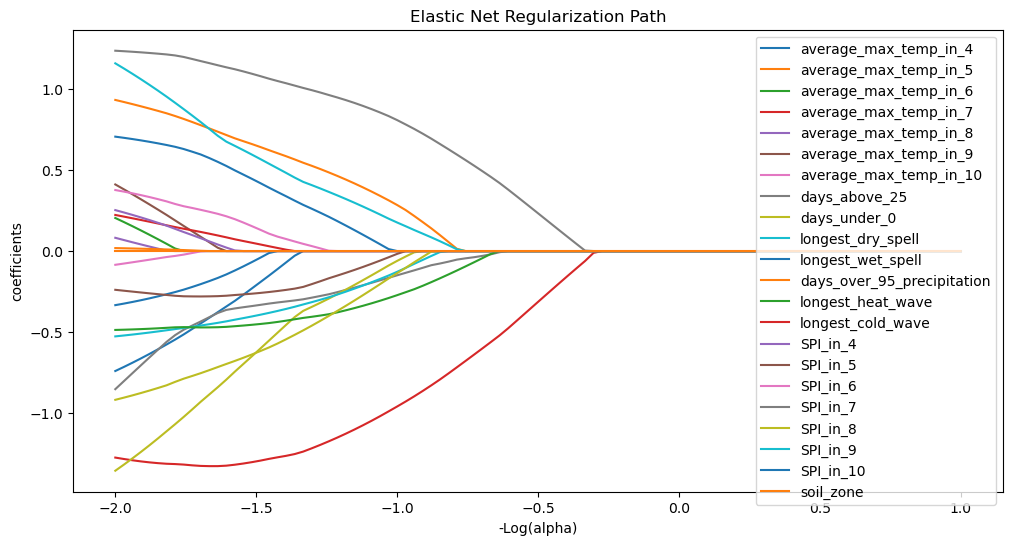

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, enet_path
from sklearn.preprocessing import StandardScaler


# Create a range of alpha values for Elastic Net
alphas_elastic_net = np.logspace(-1, 2, 100)

# Compute paths for Elastic Net
_, coefs_elastic_net, _ = enet_path(X_train_scaled, y_train, alphas=alphas_elastic_net, l1_ratio=0.5)

# Plot the Elastic Net regularization path
plt.figure(figsize=(12, 6))
neg_log_alphas_elastic_net = -np.log10(alphas_elastic_net)

for i in range(coefs_elastic_net.shape[0]):
    plt.plot(neg_log_alphas_elastic_net, coefs_elastic_net[i, :], label=X_train_scaled.columns[i])

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic Net Regularization Path')
plt.legend(loc = 'upper right')
plt.axis('tight')

In [29]:
# Assuming that coefs_lasso and alphas_lasso are obtained from the lasso_path as above
# The index corresponding to the last nonzero coefficient as alpha increases
last_nonzero_idxs = (coefs_elastic_net != 0).cumsum(axis=1).argmax(axis=1)
# Sort features by when they become zero (last to first)
sorted_features = sorted(zip(X_train_scaled.columns, last_nonzero_idxs), key=lambda x: -x[1])

# Now we extract the names of the last 10 variables to be set to zero
last_to_zero_features = [feature for feature, idx in sorted_features[:10]]

print("Last 10 variables to be set to zero by Elastic Net:")
print(last_to_zero_features)


Last 10 variables to be set to zero by Elastic Net:
['average_max_temp_in_4', 'average_max_temp_in_5', 'average_max_temp_in_6', 'average_max_temp_in_7', 'average_max_temp_in_8', 'average_max_temp_in_9', 'average_max_temp_in_10', 'days_above_25', 'days_under_0', 'longest_dry_spell']


In [ ]:
## Mixed Models 

In [64]:
# full model with year and region as random effects

formula ='Canola ~ average_max_temp_in_4 + average_max_temp_in_5 + average_max_temp_in_6 + average_max_temp_in_7 + average_max_temp_in_8 + average_max_temp_in_9 + average_max_temp_in_10 + days_above_25 + days_under_0 + longest_dry_spell + longest_wet_spell + days_over_95_precipitation + longest_heat_wave + longest_cold_wave + SPI_in_4 + SPI_in_5 + SPI_in_6 + SPI_in_7 + SPI_in_8 + SPI_in_9 + SPI_in_10 + soil_zone'

# Assuming crossed random effects without a single grouping_variable
# Note: Adjust 're_formula' and 'vc_formula' as per your exact model needs

model_full = smf.mixedlm(formula, data=feature_df_scaled, groups=feature_df_scaled['region'],
                    re_formula='1', vc_formula={'Year': '0 + C(Year)', 'region': '0 + C(region)'}) # nur random intercepts

result_full = model_full.fit()

print(result_full.summary())

C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Canola     
No. Observations:      5973        Method:                 REML       
No. Groups:            181         Scale:                  4.6240     
Min. group size:       33          Log-Likelihood:         -18382.5434
Max. group size:       33          Converged:              Yes        
Mean group size:       33.0                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  -0.158    0.105  -1.499 0.134 -0.364  0.048
soil_zone[T.2]              0.446    0.209   2.132 0.033  0.036  0.857
soil_zone[T.3]              0.725    0.425   1.705 0.088 -0.108  1.558
average_max_temp_in_4      -1.225    0.109 -11.248 0.000 -1.439 -1.012
average_max_temp_in_5  

In [65]:
# reduced model indicated by lasso 

formula = 'Canola ~ average_max_temp_in_4 + average_max_temp_in_5 + average_max_temp_in_6 + average_max_temp_in_7 + average_max_temp_in_9 + days_above_25 + days_under_0 + longest_dry_spell + longest_wet_spell + longest_heat_wave'

# Assuming crossed random effects without a single grouping_variable
# Note: Adjust 're_formula' and 'vc_formula' as per your exact model needs

model_reduced = smf.mixedlm(formula, data=feature_df_scaled, groups=feature_df_scaled['region'],
                    re_formula='1', vc_formula={'Year': '0 + C(Year)', 'region': '0 + C(region)'}) # nur random intercepts

result_reduced = model_reduced.fit()

print(result_reduced.summary())

C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Canola     
No. Observations:     5973      Method:               REML       
No. Groups:           181       Scale:                5.2726     
Min. group size:      33        Log-Likelihood:       -18776.9803
Max. group size:      33        Converged:            Yes        
Mean group size:      33.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept             -0.000    0.088  -0.000 1.000 -0.172  0.172
average_max_temp_in_4 -0.412    0.097  -4.233 0.000 -0.603 -0.221
average_max_temp_in_5  1.117    0.087  12.789 0.000  0.946  1.288
average_max_temp_in_6  0.532    0.100   5.321 0.000  0.336  0.727
average_max_temp_in_7 -2.613    0.118 -22.105 0.000 -2.845 -2.381
average_max_temp_in_9 -0

In [ ]:
# reduced model by our assumptions 

formula ='Canola ~ average_max_temp_in_4 + average_max_temp_in_5 + average_max_temp_in_7 + average_max_temp_in_9 + days_above_25 + days_under_0 + longest_dry_spell + longest_wet_spell + days_over_95_precipitation + longest_heat_wave + longest_cold_wave + SPI_in_4 + SPI_in_5 + SPI_in_6 + SPI_in_8 + SPI_in_9 + SPI_in_10 + soil_zone'

# Assuming crossed random effects without a single grouping_variable
# Note: Adjust 're_formula' and 'vc_formula' as per your exact model needs

model_reduced_2 = smf.mixedlm(formula, data=feature_df_scaled, groups=feature_df_scaled['region'],
                    re_formula='1', vc_formula={'Year': '0 + C(Year)', 'region': '0 + C(region)'}) # nur random intercepts

model_reduced_2 = model_full.fit()

print(model_reduced_2.summary())

C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regressio

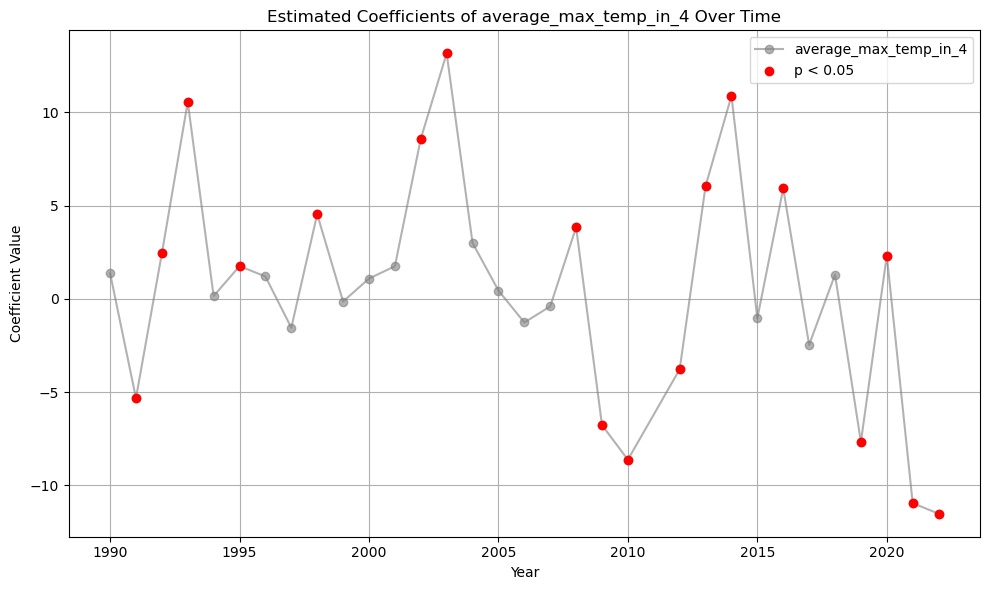

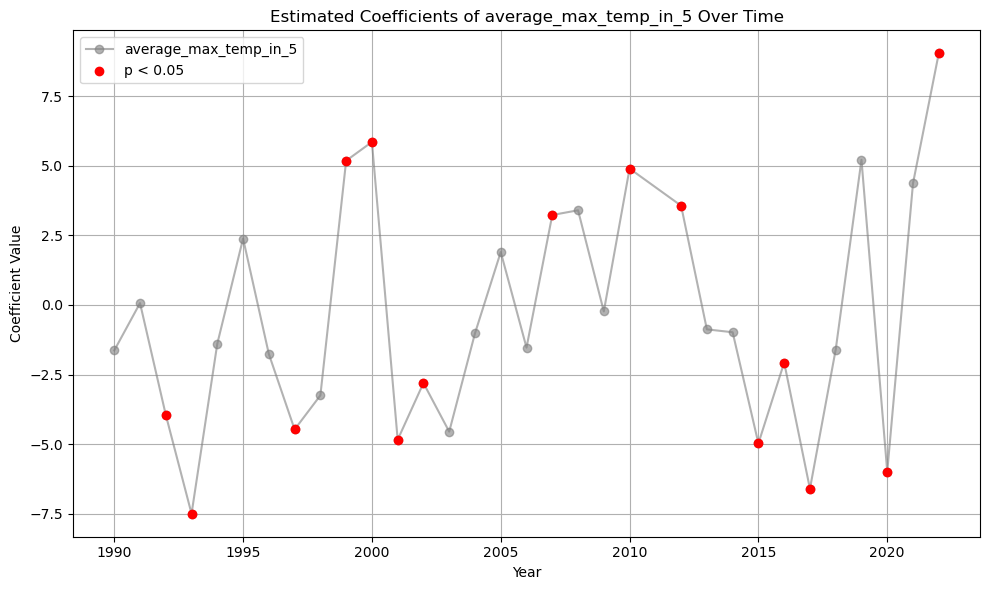

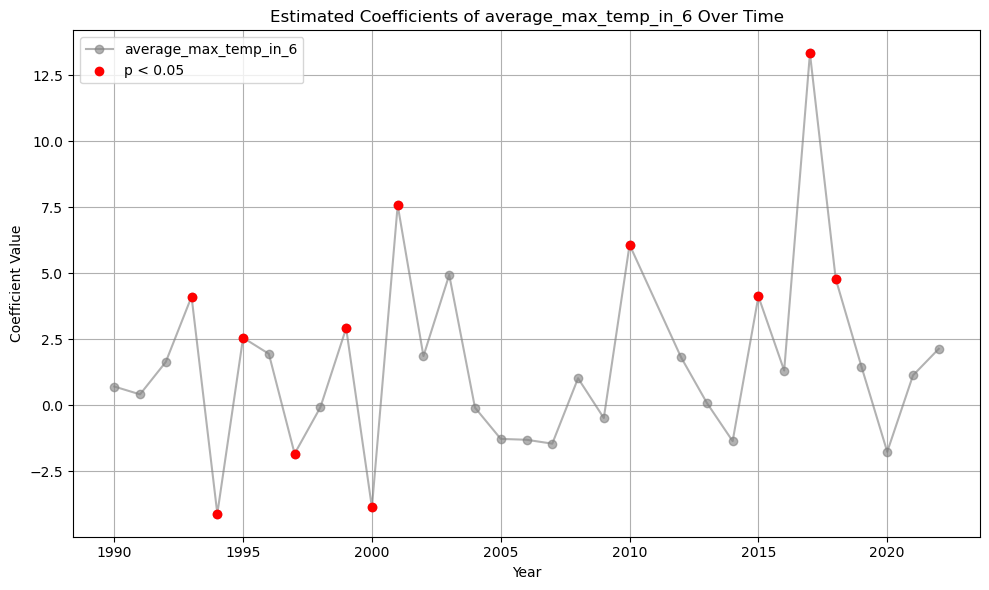

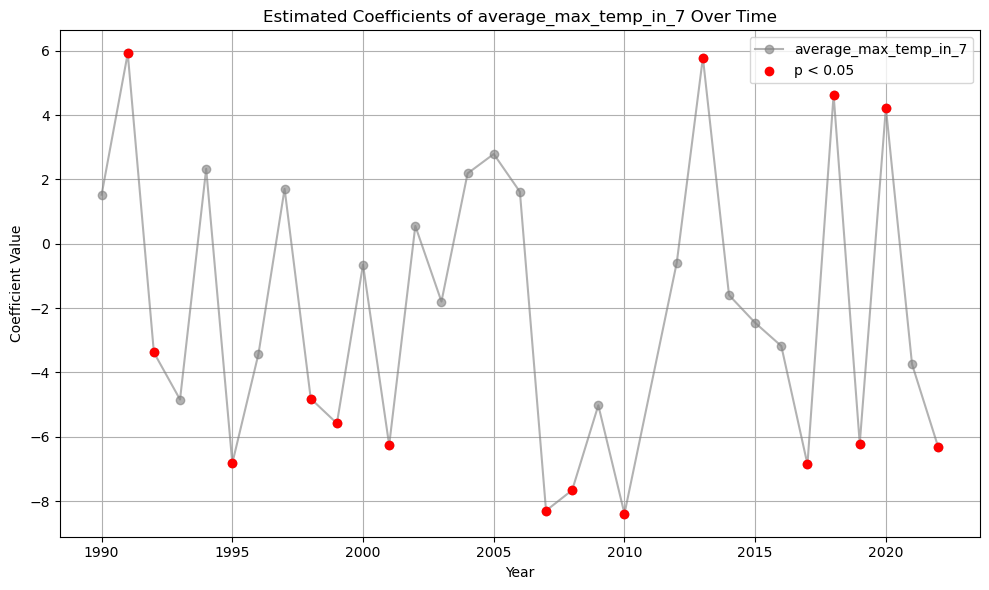

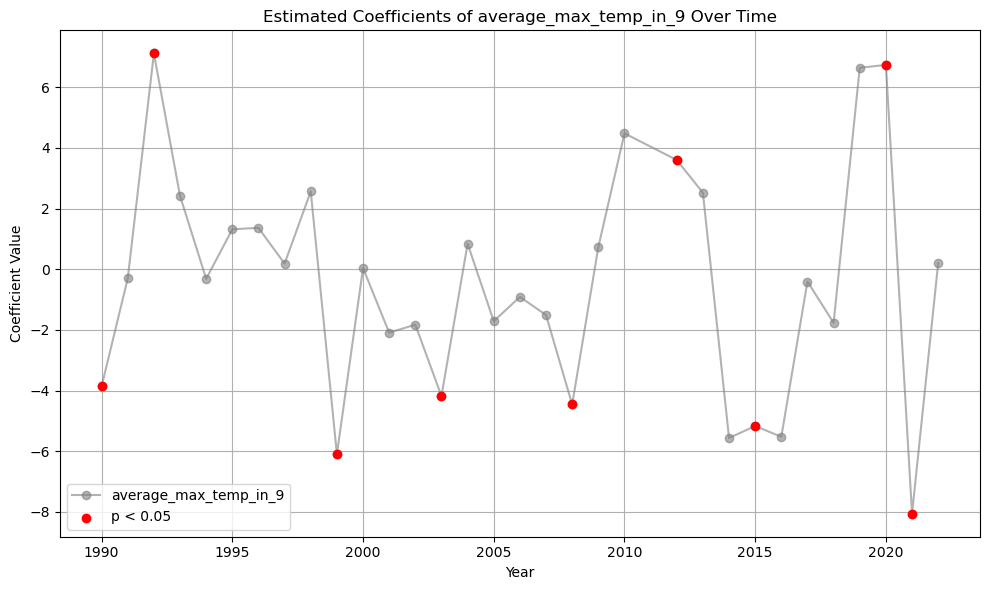

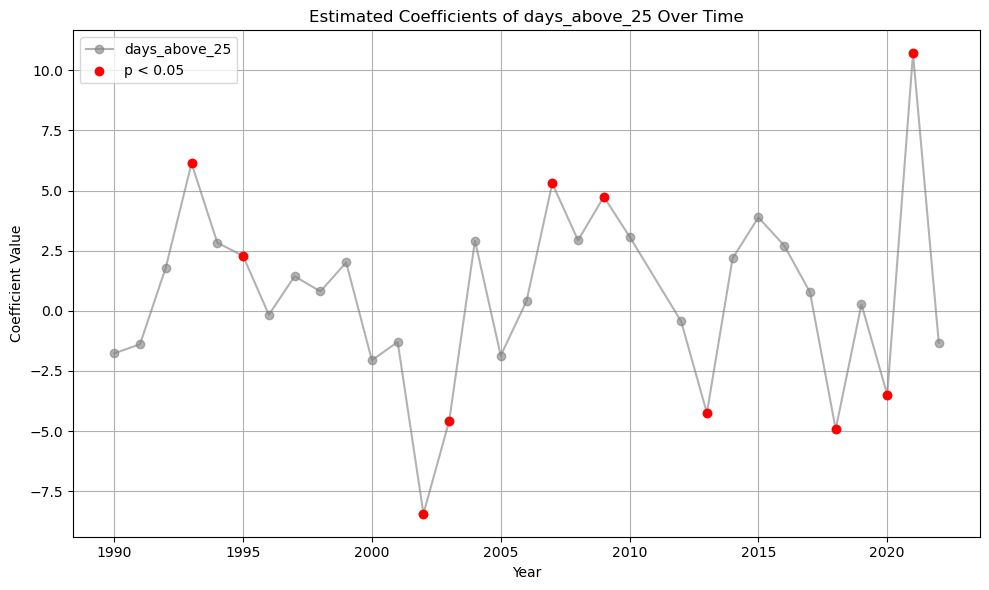

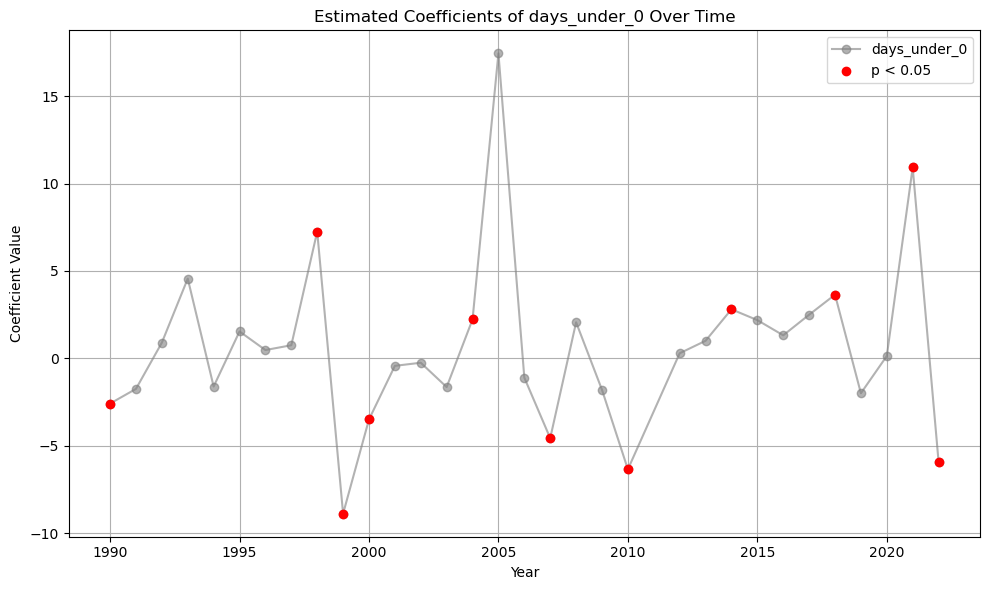

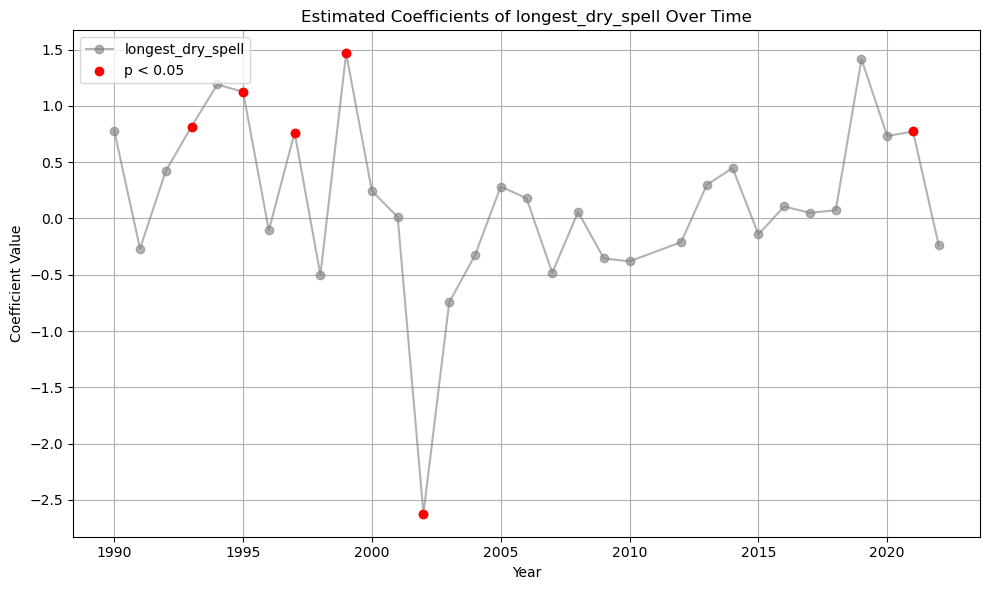

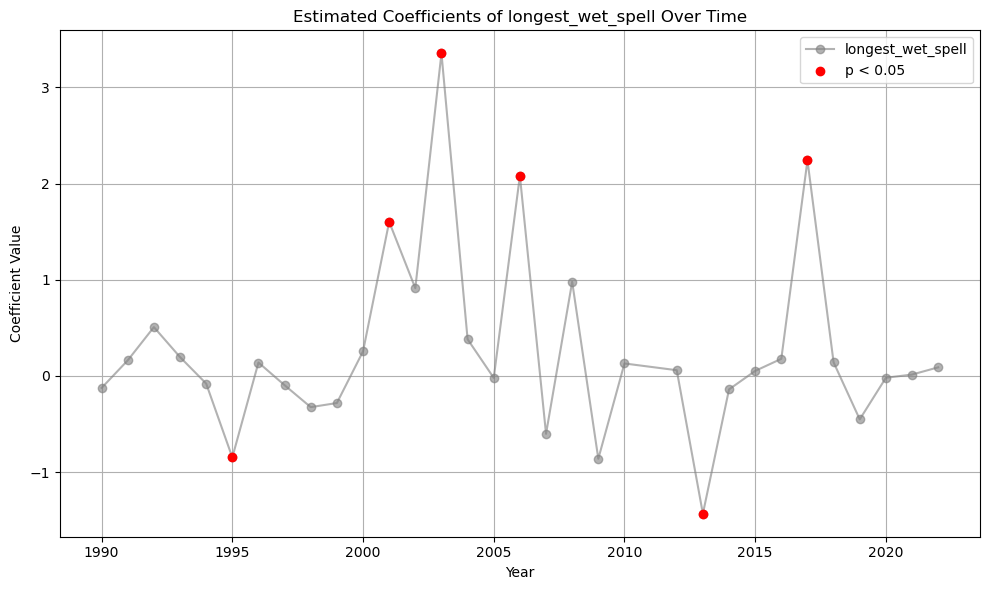

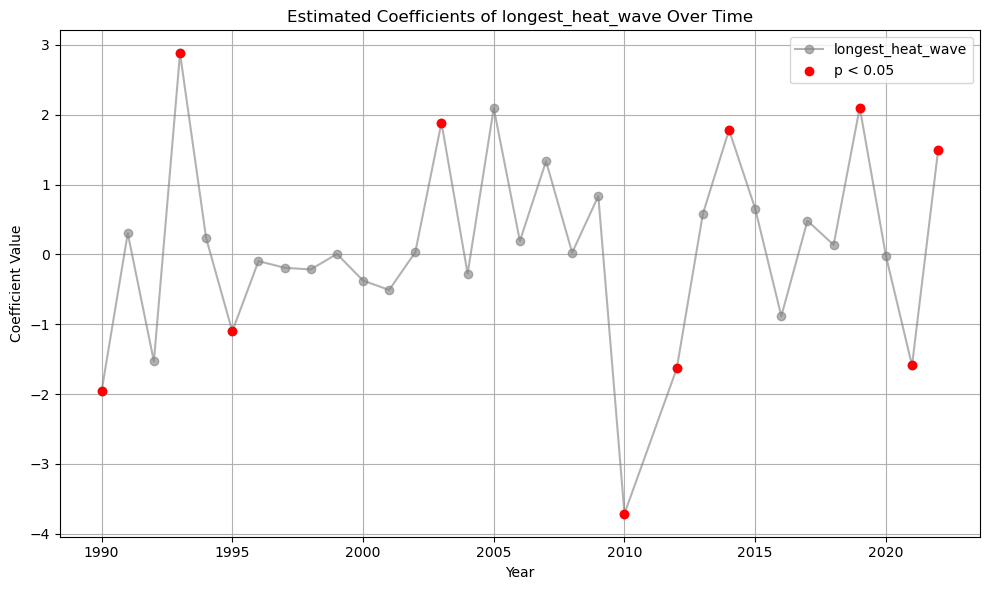

In [70]:
# Mixed moodel for only one year and with region as random effect and full features 

coefficients = {}
p_values = {}

years = years = list(range(1990, 2011)) + list(range(2012, 2023)) 
for year in years:
    feature_df_year = feature_df_scaled[feature_df_scaled['Year'] == year]
    model = smf.mixedlm(formula, data=feature_df_year, groups=feature_df_year['region'], re_formula='1')
    result = model.fit()
    
    # Collect coefficients and their p-values
    for var in result.params.keys():
        if var not in coefficients:
            coefficients[var] = []
            p_values[var] = []
        coefficients[var].append(result.params[var])
        p_values[var].append(result.pvalues[var])

import matplotlib.pyplot as plt

# Convert dictionaries to DataFrames for easier handling
coeff_df = pd.DataFrame(coefficients, index=years)
p_values_df = pd.DataFrame(p_values, index=years)

# Drop the intercept and random effects if present
coeff_df = coeff_df.drop(['Intercept', 'Group Var'], axis=1, errors='ignore')
p_values_df = p_values_df.drop(['Intercept', 'Group Var'], axis=1, errors='ignore')

# Iterate over each variable to create plots
for variable in coeff_df.columns:
    plt.figure(figsize=(10, 6))
    
    # Plot all coefficients as a line
    plt.plot(coeff_df.index, coeff_df[variable], marker='o', linestyle='-', label=variable, color='gray', alpha=0.6)
    
    # Highlight significant coefficients
    significant_years = coeff_df.index[p_values_df[variable] < 0.05]
    significant_coeffs = coeff_df.loc[p_values_df[variable] < 0.05, variable]
    plt.scatter(significant_years, significant_coeffs, color='red', label='p < 0.05', zorder=5)
    
    plt.title(f'Estimated Coefficients of {variable} Over Time')
    plt.xlabel('Year')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regressio

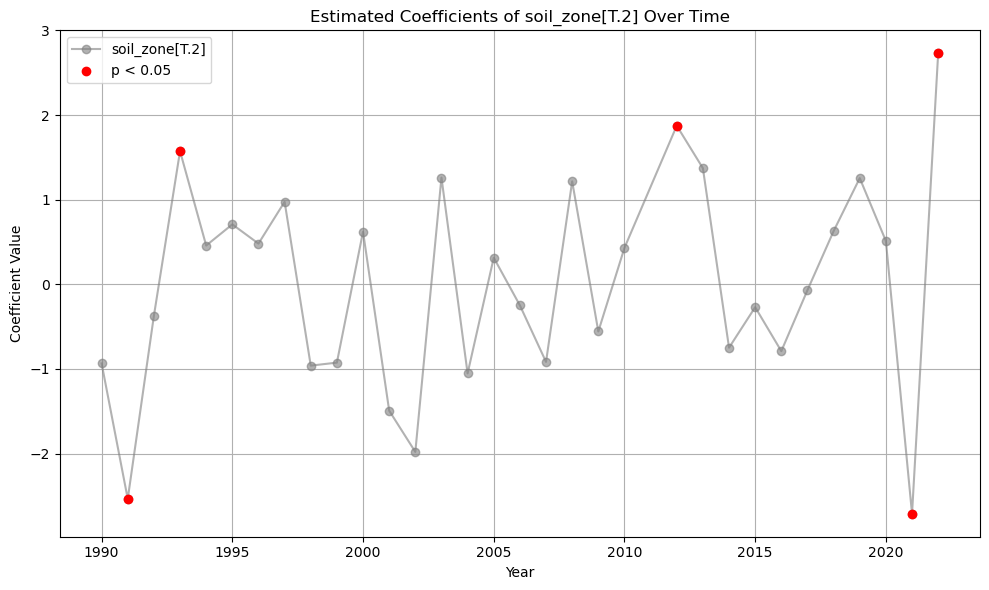

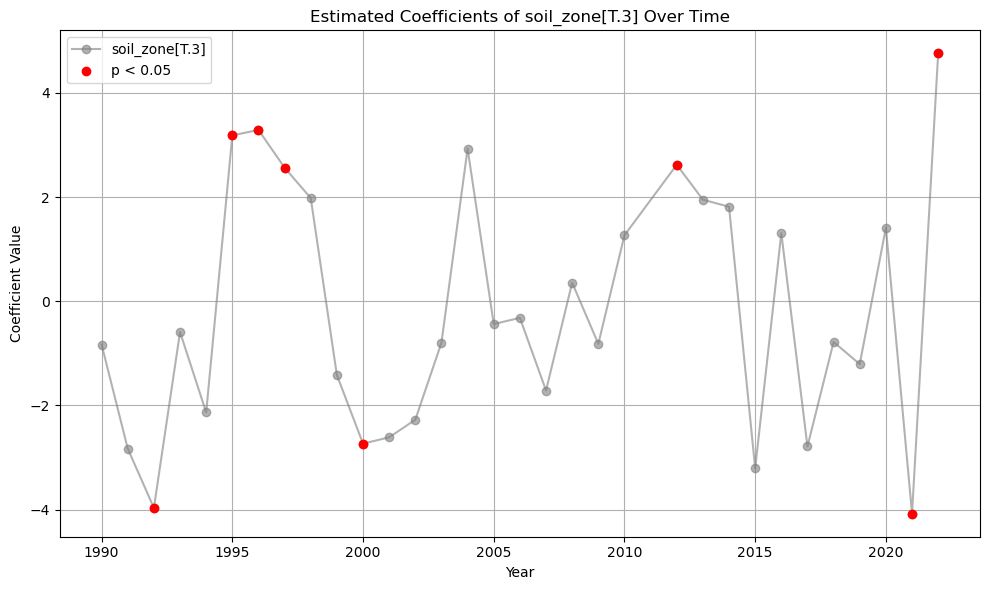

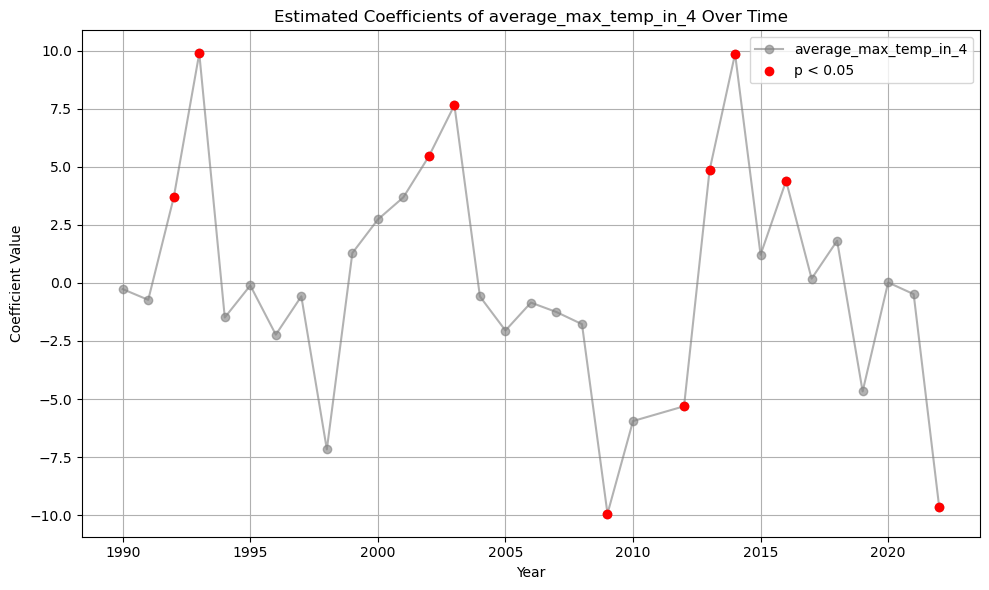

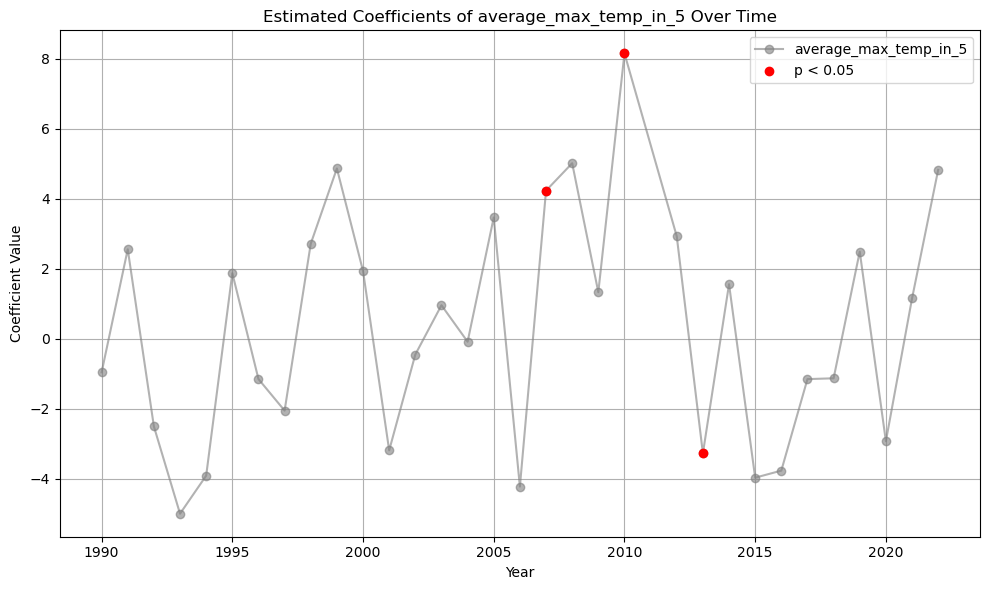

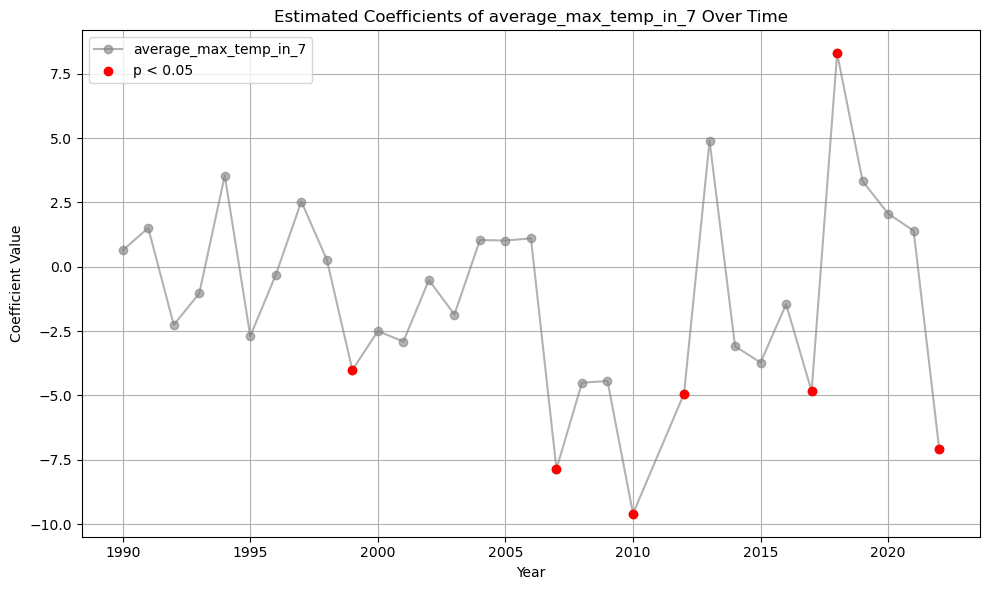

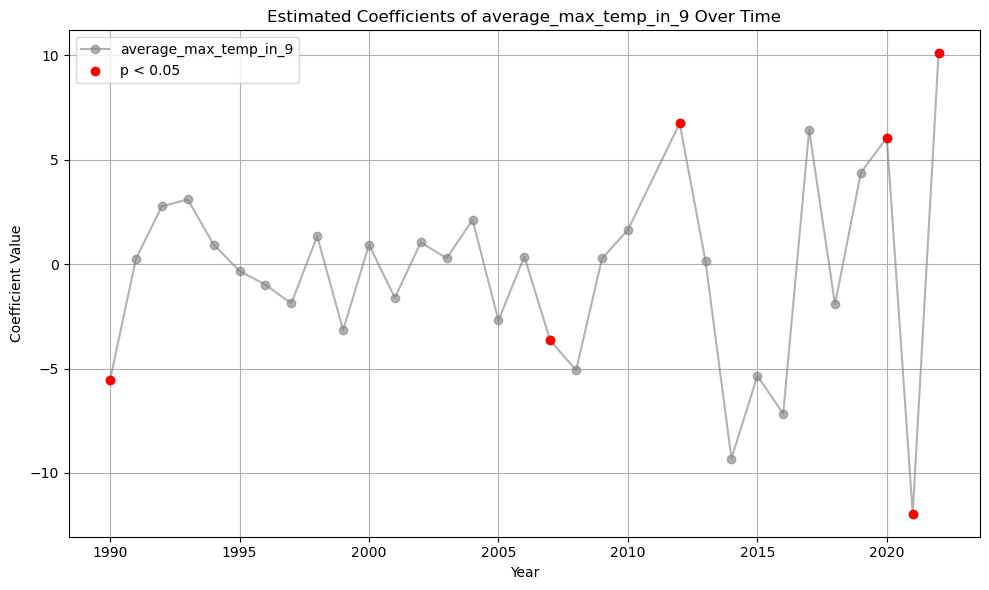

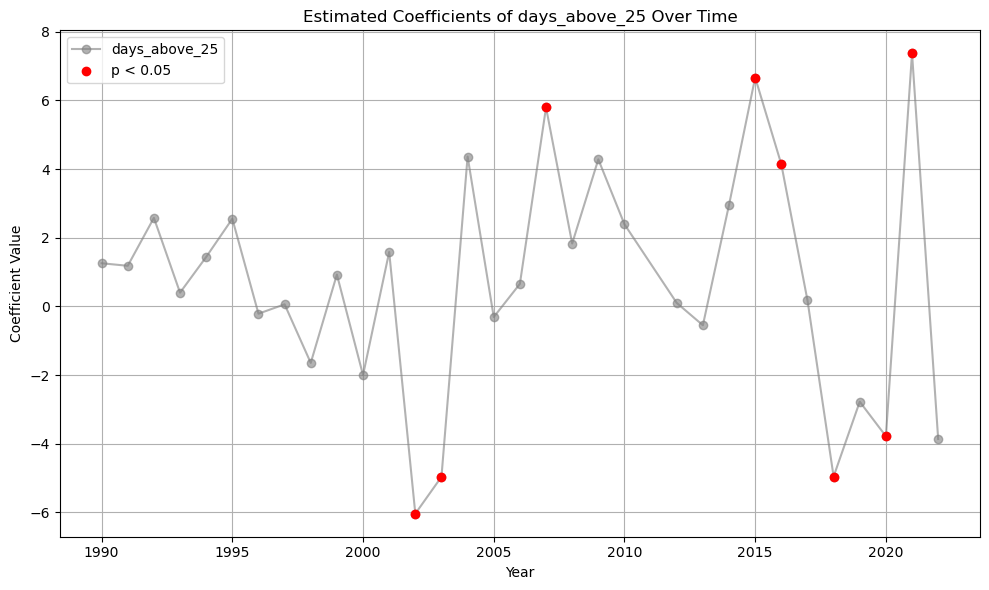

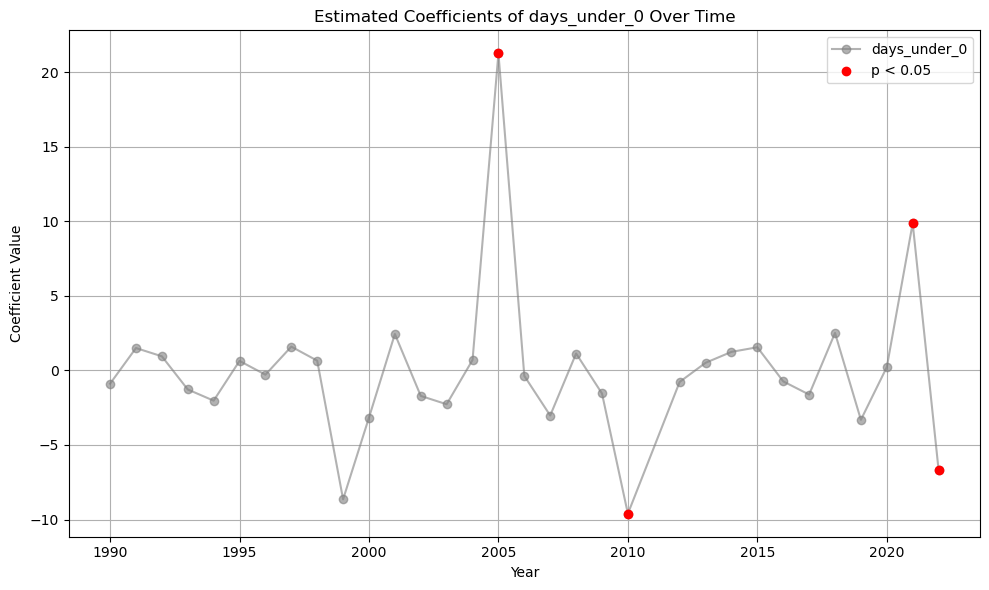

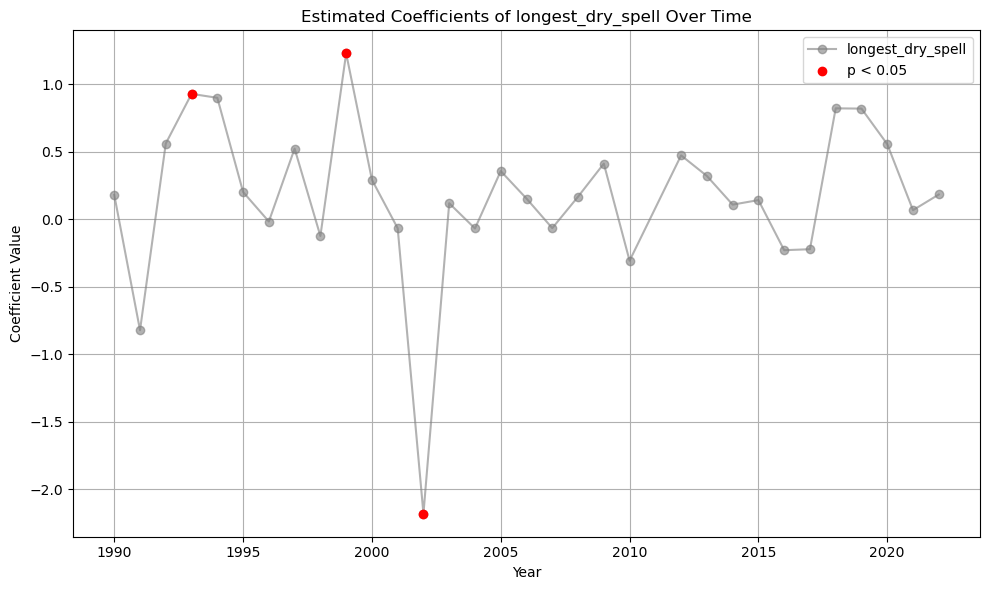

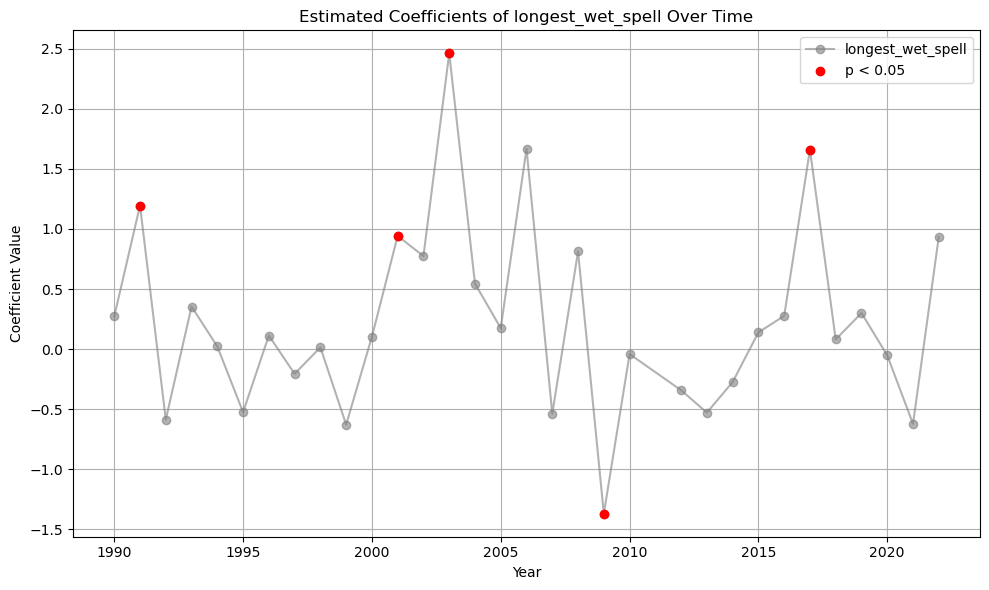

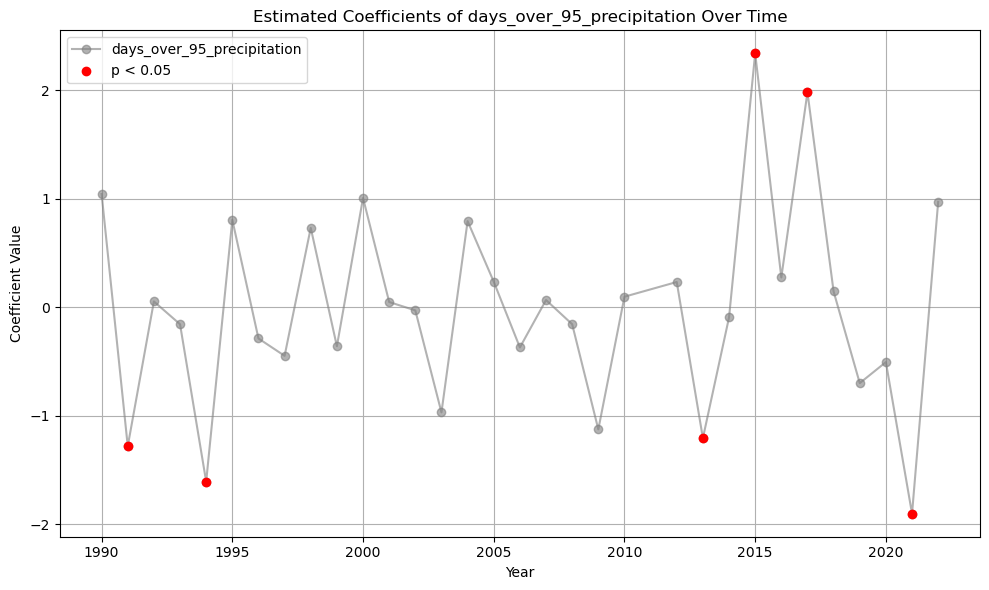

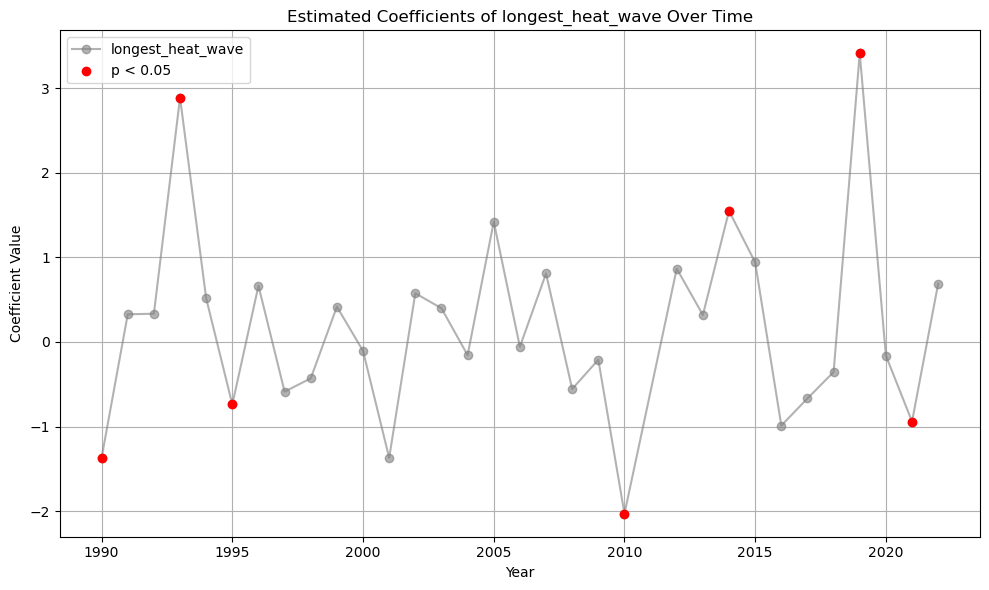

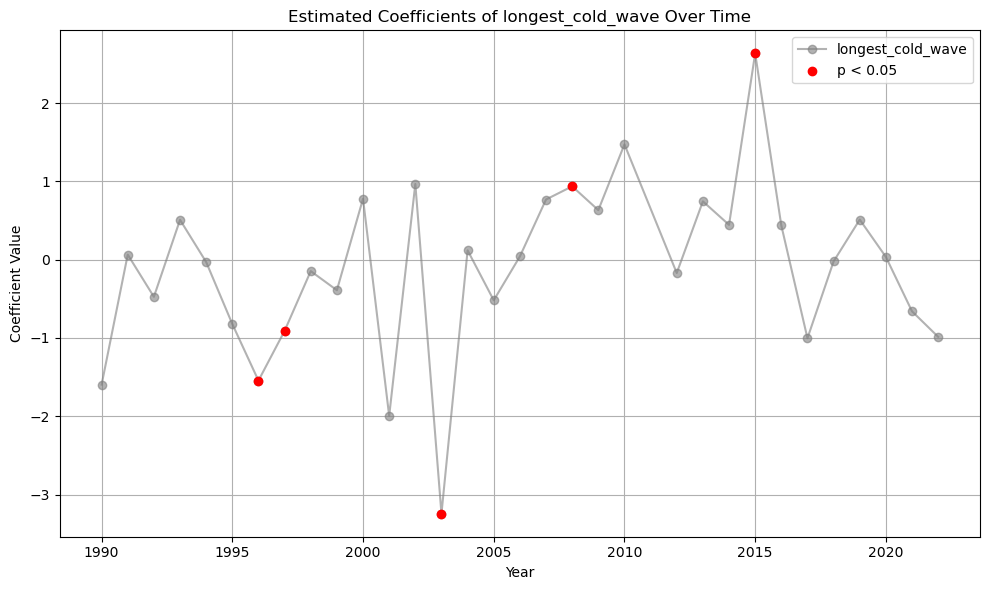

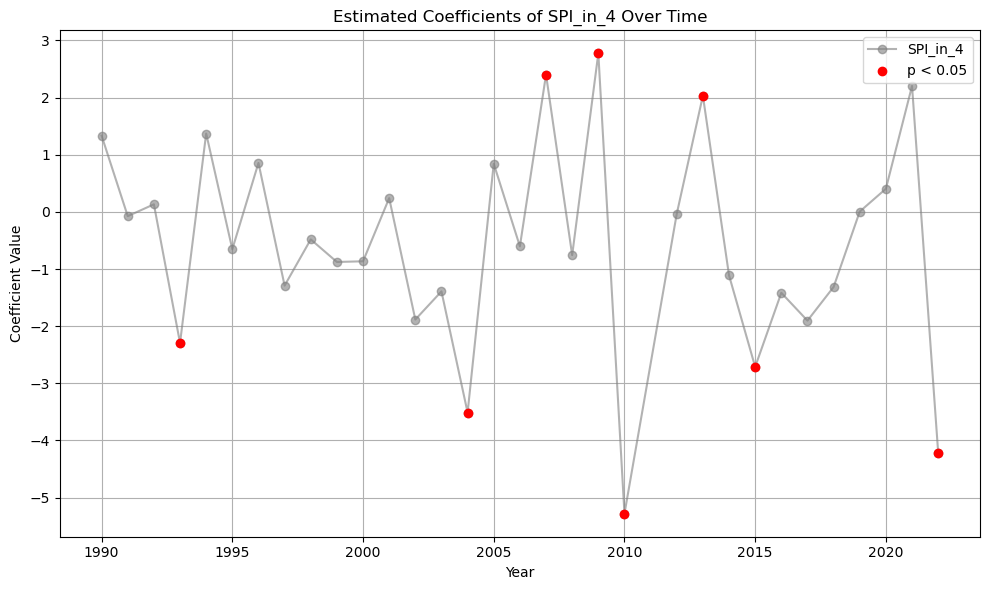

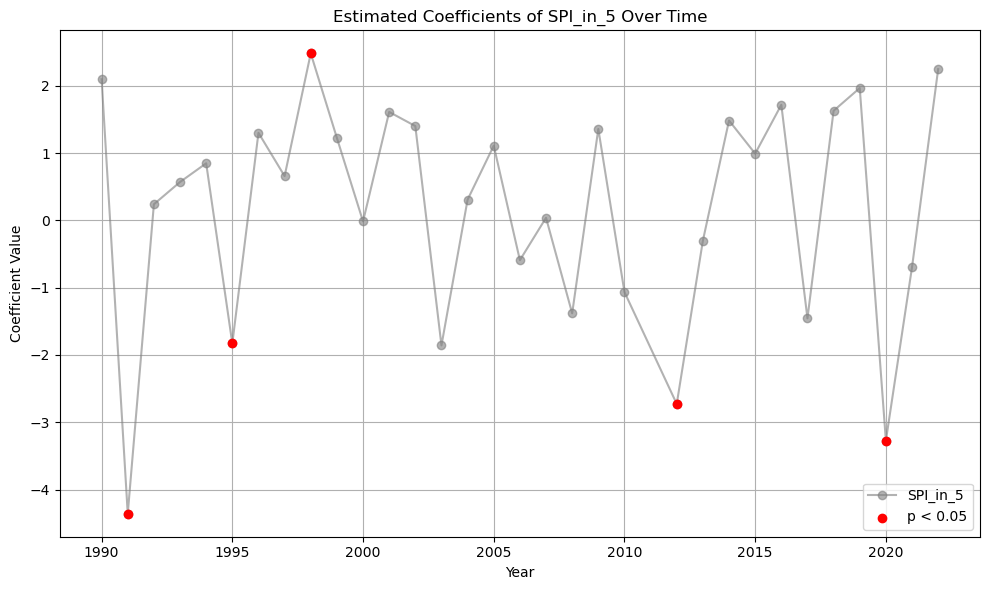

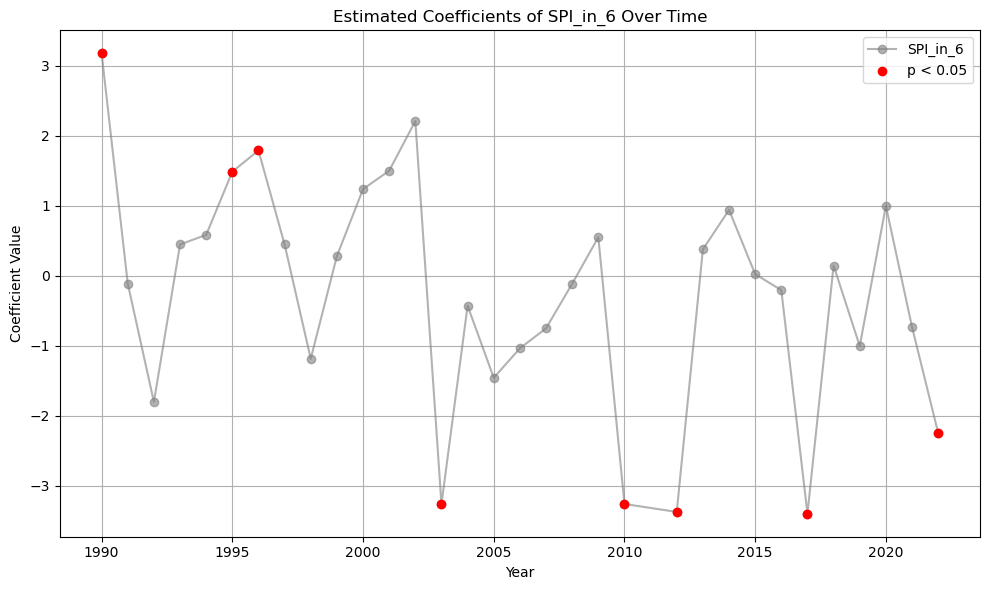

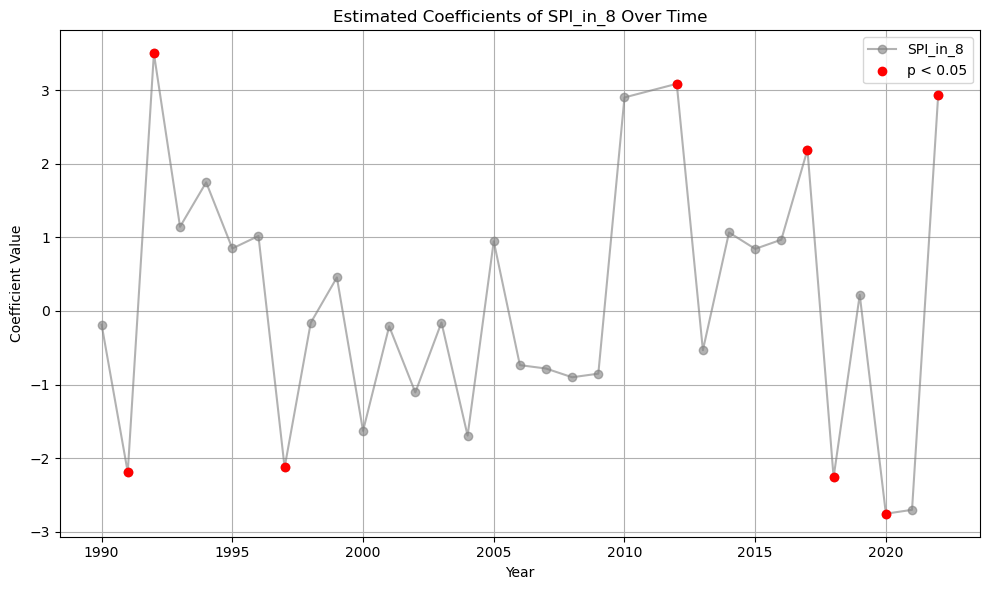

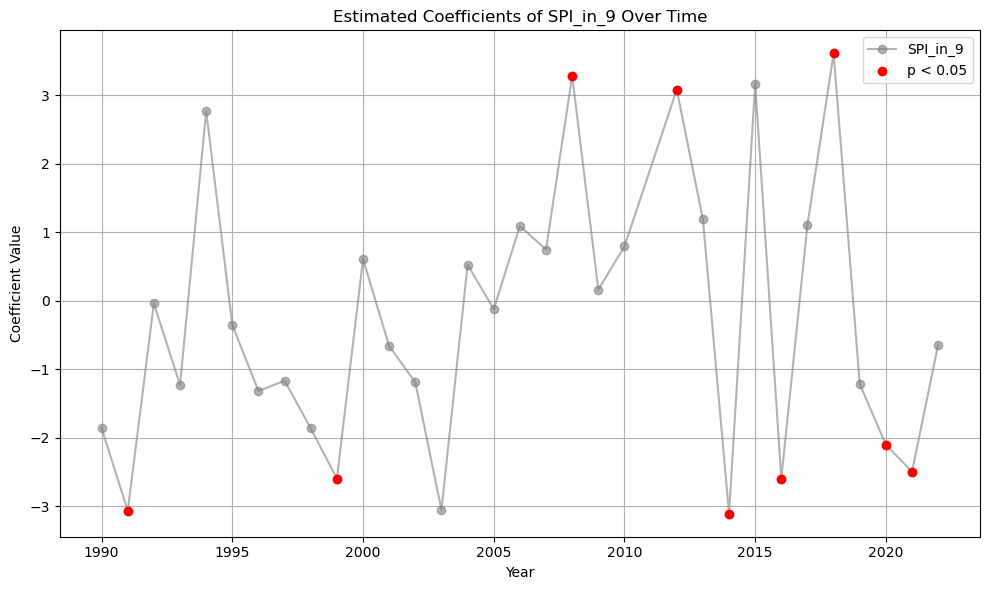

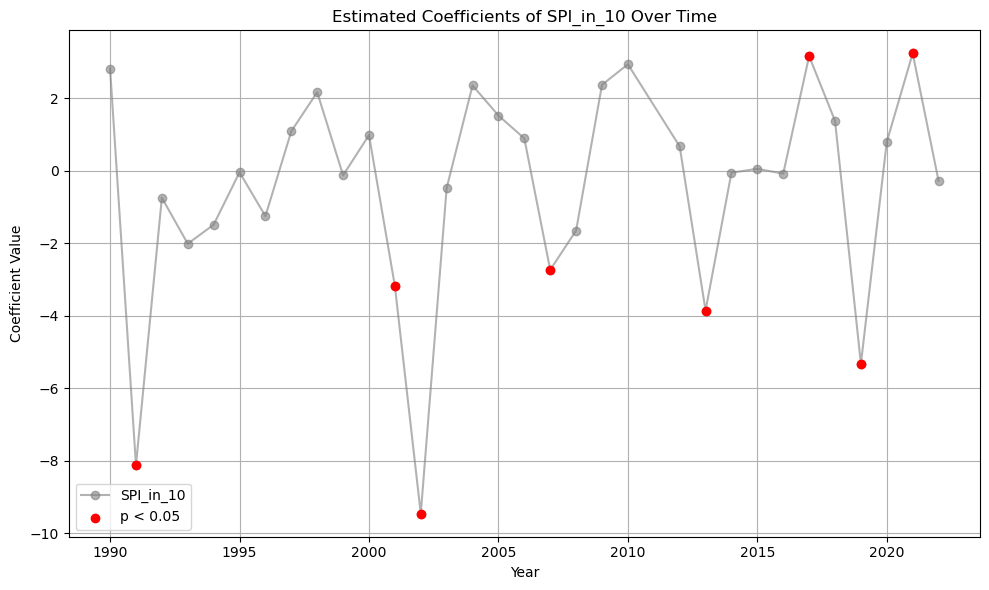

In [66]:
# Mixed moodel for only one year and with region as random effect and reduced features 

formula ='Canola ~ average_max_temp_in_4 + average_max_temp_in_5 + average_max_temp_in_7 + average_max_temp_in_9 + days_above_25 + days_under_0 + longest_dry_spell + longest_wet_spell + days_over_95_precipitation + longest_heat_wave + longest_cold_wave + SPI_in_4 + SPI_in_5 + SPI_in_6 + SPI_in_8 + SPI_in_9 + SPI_in_10 + soil_zone'

coefficients = {}
p_values = {}

years = years = list(range(1990, 2011)) + list(range(2012, 2023)) 
for year in years:
    feature_df_year = feature_df_scaled[feature_df_scaled['Year'] == year]
    model = smf.mixedlm(formula, data=feature_df_year, groups=feature_df_year['region'], re_formula='1')
    result = model.fit()
    
    # Collect coefficients and their p-values
    for var in result.params.keys():
        if var not in coefficients:
            coefficients[var] = []
            p_values[var] = []
        coefficients[var].append(result.params[var])
        p_values[var].append(result.pvalues[var])

import matplotlib.pyplot as plt

# Convert dictionaries to DataFrames for easier handling
coeff_df = pd.DataFrame(coefficients, index=years)
p_values_df = pd.DataFrame(p_values, index=years)

# Drop the intercept and random effects if present
coeff_df = coeff_df.drop(['Intercept', 'Group Var'], axis=1, errors='ignore')
p_values_df = p_values_df.drop(['Intercept', 'Group Var'], axis=1, errors='ignore')

# Iterate over each variable to create plots
for variable in coeff_df.columns:
    plt.figure(figsize=(10, 6))
    
    # Plot all coefficients as a line
    plt.plot(coeff_df.index, coeff_df[variable], marker='o', linestyle='-', label=variable, color='gray', alpha=0.6)
    
    # Highlight significant coefficients
    significant_years = coeff_df.index[p_values_df[variable] < 0.05]
    significant_coeffs = coeff_df.loc[p_values_df[variable] < 0.05, variable]
    plt.scatter(significant_years, significant_coeffs, color='red', label='p < 0.05', zorder=5)
    
    plt.title(f'Estimated Coefficients of {variable} Over Time')
    plt.xlabel('Year')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# # Assuming crossed random effects for region and Year 

# feature_df_scaled_1990 = feature_df_scaled[feature_df_scaled['Year'] == 2012]

# formula = 'Canola ~ average_max_temp_in_4 + average_max_temp_in_5 + average_max_temp_in_6 + average_max_temp_in_7 + average_max_temp_in_8 + average_max_temp_in_9 + average_max_temp_in_10 + days_above_25 + days_under_0 + longest_dry_spell + longest_wet_spell + days_over_95_precipitation + longest_heat_wave + longest_cold_wave + SPI_in_4 + SPI_in_5 + SPI_in_6 + SPI_in_7 + SPI_in_8 + SPI_in_9 + SPI_in_10 + soil_zone'

# # Assuming a random intercept for region

# model = smf.mixedlm(formula, data=feature_df_scaled_1990, groups=feature_df_scaled_1990['region'],
#                     re_formula='1')
# result = model.fit()

# print(result.summary())

# # residuals = result.resid
# # fig = sm.qqplot(residuals, line='s')
# # plt.show()

In [68]:
# reduced model indicated by lasso 

formula = 'Canola ~ average_max_temp_in_4 + average_max_temp_in_5 + average_max_temp_in_6 + average_max_temp_in_7 + average_max_temp_in_9 + days_above_25 + days_under_0 + longest_dry_spell + longest_wet_spell + longest_heat_wave'

# Assuming crossed random effects without a single grouping_variable
# Note: Adjust 're_formula' and 'vc_formula' as per your exact model needs

model_reduced_unscaled = smf.mixedlm(formula, data=feature_df, groups=feature_df['region'],
                    re_formula='1', vc_formula={'Year': '0 + C(Year)', 'region': '0 + C(region)'}) # nur random intercepts

result_reduced_unscaled = model_reduced.fit()

print(result_reduced_unscaled.summary())

C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Canola     
No. Observations:       5973        Method:                 REML       
No. Groups:             181         Scale:                  5.2726     
Min. group size:        33          Log-Likelihood:         -18788.6743
Max. group size:        33          Converged:              Yes        
Mean group size:        33.0                                           
-----------------------------------------------------------------------
                       Coef.    Std.Err.     z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept             237.416      34.013   6.980 0.000 170.751 304.081
average_max_temp_in_4  -0.135       0.032  -4.233 0.000  -0.197  -0.072
average_max_temp_in_5   0.584       0.046  12.789 0.000   0.494   0.673
average_max_temp_in_6   0.297       0.056   5.321 0.000   0.187   0.406
average_m